# Monitoring coastal change and erosion with Landsat

### Background
Over 40% of the world’s population lives within 100 km of the coastline. However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

### The Problem
Monitoring coastlines and rivers using field surveys can be challenging and hazardous, particularly at regional or national scale. Aerial photography and LiDAR can be used to monitor coastal change, but this is often expensive and requires many repeated flights over the same areas of coastline to build up an accurate history of how the coastline has changed across time.

### Digital Earth Australia use case
Imagery from satellites such as the NASA/USGS Landsat program is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring coastlines and rivers at regional or national scale. By identifying and extracting the precise boundary between water and land based on satellite data, it is possible to extract accurate shorelines that can be compared across time to reveal hotspots of erosion and coastal change.

The usefulness of satellite imagery in the coastal zone can be affected by the presence of clouds, sun-glint over water, poor water quality (e.g. sediment) and the influence of tides. The effect of these factors can be reduced by combining individual noisy images into cleaner "summary" or composite layers, and filtering the data to focus only on images taken at certain tidal conditions (e.g. high tide). 

In this example, we combine data from the Landsat 8 satellite with image compositing and tide filtering techniques to accurately map shorelines across time, and identify areas that have changed significantly between 2013 and 2018. The worked example takes users through the code required to:

1.  Load in a cloud-free Landsat time series
2.  Compute a water index (MNDWI)
3.  Filter images by tide height
4.  Create "summary" or composite images for given time periods
5.  Extract and visualise shorelines across time

### Technical details

Products used: `ls8_nbar_scene`

Analyses used: MNDWI water index, tide filtering, compositing, waterline extraction

**To run this analysis, run all cells starting with "Load modules". When you are done, return to the "Set up analysis" cell, modify some values (e.g. choose a different location, time, tide height range or time period to analyse) and re-run the analysis.**


## Load modules

In [1]:
import datacube
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import waterline_funcs


## Set up analysis (edit these lines!)

The following lines allow us to set up our analysis by selecting the location (`lat_range` and `lon_range`) and time (`time_range`) we want to investigate. We can also set two other important parameters: `tide_range` allows us to extract shorelines based on satellite images taken only at certain part of the tide range (e.g. at low or high tide). This can be useful for seperating the effect of erosion from the influence of tides. Finally, the `time_step` parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc:

* **lat_range:** The latitude range to analyse (e.g. `(-12.20, -12.27)`). For fast load times, keep this to a range of no more than 0.1 degrees.

* **lon_range:** The longitude range to analyse (e.g. `(131.80, 131.91)`). For fast load times, keep this to a range of no more than 0.1 degrees.

* **time_range:** The date range to analyse (e.g. `('2013-01-01', '2018-12-31') `)

* **tide_range:** The lowest and highest tide heights to analyse (e.g. `(0.00, 2.00)` in metre units). This will remove all images with tides outside this range from the dataset, allowing you to produce shorelines for specific tidal conditions (e.g. low tide, average tide, high tide etc)

* **time_step:** The time period to compare coastline change. `1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.


In [2]:
lat_range = (-13.39, -13.47) 
lon_range = (130.27, 130.35) 
time_range = ('2013-01-01', '2018-12-31') 
tide_range = (0.00, 2.00)
time_step = '1Y'

## Load cloud-masked Landsat data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. The code below first connects to the datacube database, and then uses the `load_cloudmaskedlandsat` function to load in data from the Landsat 8 satellite for the area and time included in `lat_range`, `lon_range` and `time_range`. The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [3]:
# Connect to the datacube
dc = datacube.Datacube(app='Coastal erosion')

# Create 'query' based on the longitudes, latitudes and time provided above
query = {'y': lat_range,
         'x': lon_range,
         'time': time_range,
         'output_crs': 'EPSG:28352',
         'resolution': (-25, 25)}

# Load Landsat 8 data for the time and area in the query. This may take several minutes!
landsat_ds = waterline_funcs.load_cloudmaskedlandsat(dc=dc, 
                                                   query=query, 
                                                   platform='ls8', 
                                                   bands=['red', 'green', 'blue', 'swir1'])
print(landsat_ds)


Loading data for 129 ls8 observations
Loading pixel quality data for 129 ls8 observations
Masking out poor quality pixels (e.g. cloud)
<xarray.Dataset>
Dimensions:  (time: 129, x: 349, y: 357)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-23T01:25:30.500000 ... 2018-12-29T01:23:04
  * y        (y) float64 8.519e+06 8.519e+06 8.519e+06 ... 8.511e+06 8.51e+06
  * x        (x) float64 6.375e+05 6.375e+05 6.375e+05 ... 6.461e+05 6.462e+05
Data variables:
    red      (time, y, x) float64 644.0 647.0 632.0 ... 1.417e+03 1.406e+03
    green    (time, y, x) float64 724.0 733.0 736.0 ... 1.313e+03 1.312e+03
    blue     (time, y, x) float64 551.0 545.0 544.0 550.0 ... 937.0 939.0 941.0
    swir1    (time, y, x) float64 1.421e+03 1.433e+03 1.418e+03 ... 149.0 149.0
Attributes:
    crs:      EPSG:28352


### Plot example timestep in true colour
To verify that we extracted data for the area we're interested in analysing, we can plot up the first image in the dataset in true colour. Change `index=0` to another value (e.g. `index=1`) to plot up different timesteps!

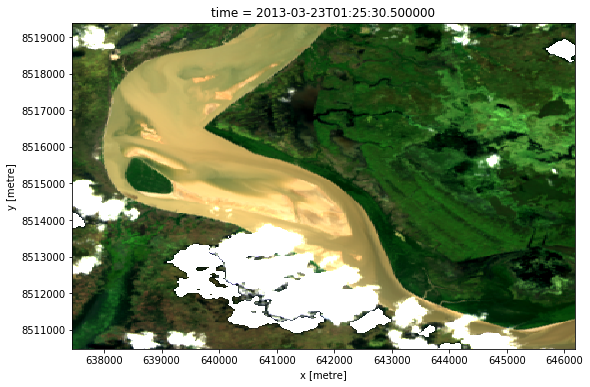

In [4]:
waterline_funcs.rgb(landsat_ds, index=0)

## Compute Modified Normalised Difference Water Index
To extract shoreline locations, we need to be able to seperate water from land in our study area. To do this, we can use our Landsat data to calculate a water index called the `Modified Normalised Difference Water Index`, or MNDWI.

This index uses the ratio of green and short-wave infrared radiation to identify the presence of water. <font color='blue'>**High values (greater than 0, blue colours) typically represent water pixels**</font>, while <font color='red'>**low values (less than 0, red colours) represent land**</font>:

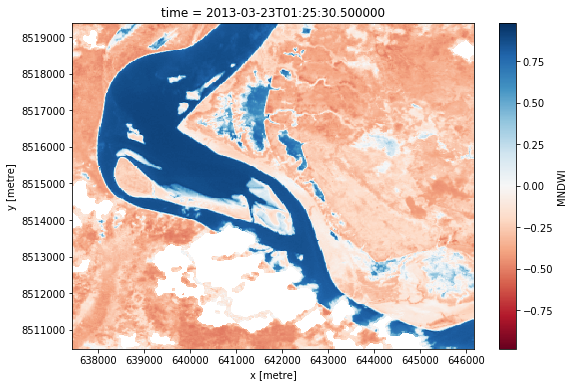

In [5]:
landsat_ds['MNDWI'] = (landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)
landsat_ds.MNDWI.isel(time=0).plot(cmap='RdBu', size=6)  

## Import tide height data
The location of the shoreline can vary greatly from low to high tide. In the code below, we aim to reduce the effect of tides by loading in tide height data, and keeping only the satellite images that were taken at specific tidal conditions. For example, if `tide_range = (0.00, 2.00)`, we are telling the analysis to focus only on satellite images taken when the tide was between `0.00 m` and `2.00 m` relative to Mean Sea Level.

For this example notebook, we will use tide data for a single location off the coast of Darwin, Northern Territory. However, a more accurate analysis would require local tide data for each location being analysed.

In [6]:
tide_data = pd.read_csv('darwin_tides.csv', parse_dates=['time'], index_col='time')
tide_data.head()

,tide_height
time,
2013-01-01 00:00:00,1.511
2013-01-01 00:30:00,1.120
2013-01-01 01:00:00,0.643
2013-01-01 01:30:00,0.111
2013-01-01 02:00:00,-0.447


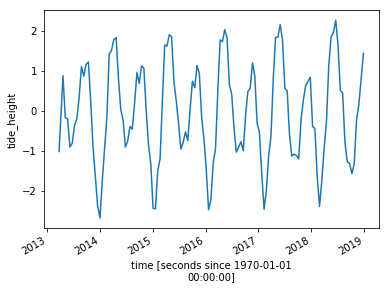

In [7]:
# First, we convert the data to an xarray dataset so we can analyse it in the same way as our Landsat data
tide_data_xr = tide_data.to_xarray()

# We want to convert our hourly tide heights to estimates of exactly how high the tide was at the time that
# each satellite image was taken. To do this, we can use `.interp` to 'interpolate' a tide height for each
# Landsat timestamp:
landsat_tideheights = tide_data_xr.interp(time=landsat_ds.time)

# We then want to put these values back into the Landsat dataset so that each image has an estimated tide height:
landsat_ds['tide_height'] = landsat_tideheights.tide_height

# Plot the resulting tide heights for each Landsat image:
landsat_ds.tide_height.plot()

### Filter Landsat images by tide height
Here we take the Landsat dataset, and keep only the images with tide heights we want to analyse (i.e. tides with the range given my `tide_range`). This will result in a smaller number of images (e.g. 59 images compared to 129):

In [8]:
landsat_hightide = landsat_ds.where((landsat_ds.tide_height > tide_range[0]) & 
                                    (landsat_ds.tide_height < tide_range[1]), drop=True)
landsat_hightide

<xarray.Dataset>
Dimensions:      (time: 59, x: 349, y: 357)
Coordinates:
  * time         (time) datetime64[ns] 2013-04-19T01:24:59.500000 ... 2018-12-29T01:23:04
  * y            (y) float64 8.519e+06 8.519e+06 ... 8.511e+06 8.51e+06
  * x            (x) float64 6.375e+05 6.375e+05 ... 6.461e+05 6.462e+05
Data variables:
    red          (time, y, x) float64 478.0 464.0 470.0 ... 1.417e+03 1.406e+03
    green        (time, y, x) float64 492.0 512.0 517.0 ... 1.313e+03 1.312e+03
    blue         (time, y, x) float64 287.0 292.0 289.0 ... 937.0 939.0 941.0
    swir1        (time, y, x) float64 1.444e+03 1.47e+03 ... 149.0 149.0
    MNDWI        (time, y, x) float64 -0.4917 -0.4834 -0.4757 ... 0.7962 0.796
    tide_height  (time) float64 0.8816 0.3451 1.108 ... 0.1524 0.7954 1.439
Attributes:
    crs:      EPSG:28352

## Create water index summary images
Individual remote sensing images can be affected by noisy data, including clouds, sunglint and poor water quality conditions (e.g. sediment). To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the 'typical' or median appearance of the landscape for a certain time period. 

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '1Y'`, the code will produce one new image for each year of data in the dataset:

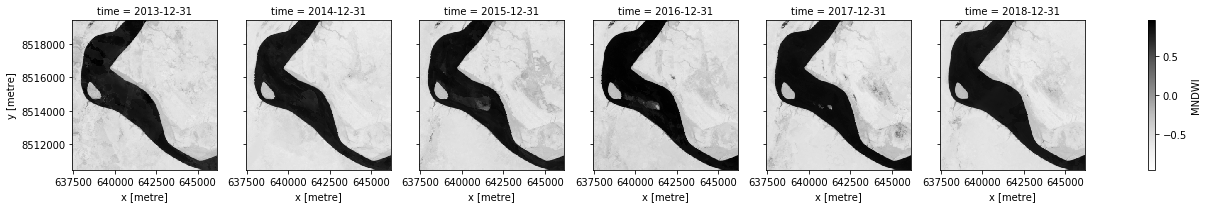

In [9]:
# Combine by time
landsat_resampled = landsat_hightide.MNDWI.resample(time=time_step).median('time')
landsat_resampled.plot(col='time', cmap='Greys', col_wrap=6)

## Extract shorelines from imagery
We now want to extract an accurate shoreline for each each of the summary images above (e.g. 2013, 2014 etc summaries). The code below identifies the boundary between land and water by tracing a line along pixels with a water index value of `0` (halfway between land and water water index values). It returns a shapefile with one line for each time step:


Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
    Extracting contour 2
    Extracting contour 3
    Extracting contour 4
    Extracting contour 5
Exporting contour shapefile to output_waterlines.shp


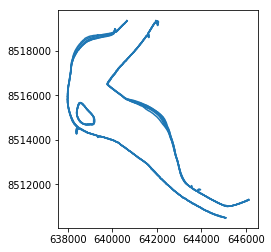

In [10]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in landsat_resampled.time.values]}
attribute_dtypes = {'time': 'str'}

# Extract waterline contours for the '0' water index threshold:
contour_gdf = waterline_funcs.contour_extract(z_values=[0],
                                              ds_array=landsat_resampled,
                                              ds_crs=landsat_ds.crs,
                                              ds_affine=landsat_ds.geobox.transform,
                                              output_shp=f'output_waterlines.shp',
                                              attribute_data=attribute_data,
                                              attribute_dtypes=attribute_dtypes,
                                              min_vertices=100)

# Plot output shapefile
contour_gdf.plot()

### Plot interactive map of output shorelines coloured by time
Zoom in to the map below to explore the resulting set of shorelines. Older shorelines are coloured in yellow; more recent shorelines in red (click on the shorelines to return their time period). Using this data, we can easily identify areas of rivers or coastline that have changed significantly over time, or areas that have remained stable over the past 5 years.

In [11]:
waterline_funcs.map_shapefile(gdf=contour_gdf)

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

## Next steps
1. When you are done, return to the "Set up analysis" cell, modify some values (e.g. choose a different location, time, tide height range or time period to analyse) and re-run the analysis. Check this link to make sure you are choosing a location that has data in the datacube: https://dashboard.dea-sandbox.test.frontiersi.io/
